# HPC CW4

In [1]:
%matplotlib inline
import numpy as np
import numexpr as ne
from numba import njit
import pyopencl as cl
from matplotlib import pyplot as plt

## Class Timer

In [2]:
import time

class Timer:    
    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, *args):
        self.end = time.time()
        self.interval = self.end - self.start

## The SIAM 100-Digit Challenge: A Study in High-Accuracy Numerical Computing
### In the Moment of Heat

We consider a square plate with sides by $[-1, 1] \times [-1, 1]$.

The temperature evolves according to, $u_t = \Delta u$. We suppose that at time $t∗$, the plate reaches $u=1$ at the center of the plate.


We choose positive integer $m, n$, we define a time step $\Delta t = \frac T m$ and a mesh size $h = \frac 2 n$ in space. Let n be odd number, then the single center point is $(\frac{n-1}2, \frac{n-1}2)$.


We know that

$$u_h (t, x, y) = u_h(t-\Delta t, x, y)-\frac{\Delta t}{h^2} (4u_h(t-\Delta t, x-h, y) - u_h(t-\Delta t, x+h, y) - u_h(t-\Delta t, x, y-h) - u_h(t-\Delta t, x, y+h),$$

using the boundary or initial values whenever it is necessary. As is well known, for being stable this recursion requires a bound on the time step, $$\frac {\Delta t} {h^2} \leq \frac 1 4.$$

Such a bound is called a CFL condition for Courant, Friedrichs, and Lewy. We choose $\Delta t = c_t h^2$, with a constant Courant number $c_t \leq \frac1 4$ depending on $T$.

To twelve digits the wanted sopution is $t* = 0.424011387033$.

We use finite differences to calculate time $t*$.

In the following codes, I will analyze differents methods: <font color="green">Numba, Array, Numexpr, OpenCL, Runge Kutta 4</font>.


We set:

$n = 101$

$m = 20000$

$c = \frac {(n - 1) ^2 } {4m} = 0.125$  (Courant Nmber)

## Numba 
### int 64

t* = 0.424
Total time: 0.793877363204956


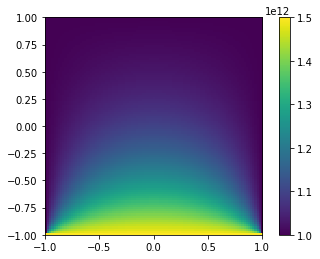

In [3]:
@njit
def f_nb_int(n, m, u):
    '''
    This function
    '''
    v = np.copy(u)
    for r in range(1, n - 1):
        for c in range(1, n - 1):
            v[r, c] = u[r, c] - (4 * u[r, c] - u[r - 1, c] - u[r + 1, c] - u[r, c - 1] - u[r, c + 1]) * (n - 1) * (n - 1) / (4 * m)

    return v

n = 101
m = 20000

u = np.full((n, n), 1_000_000_000_000, dtype=np.int64)
u[0, :] = 1_500_000_000_000

i = 0

with Timer() as t:
    
    while u[(n - 1) // 2, (n - 1) // 2] < 1_100_000_000_000:
        u = f_nb_int(n, m, u)
        i = i + 1
    
print("t* =", i / m)
print("Total time: {0}".format(t.interval))

plt.figure()
plt.imshow(u, origin='lower', extent=(-1, 1, -1, 1))
plt.colorbar()
plt.show()

## Numba 
### float 64

t* = 0.424
Total time: 0.39294862747192383


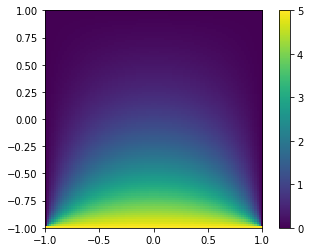

In [4]:
@njit
def f_nb_fl(n, m, u):
    '''
    This function
    '''
    v = np.copy(u)
    for r in range(1, n - 1):
        for c in range(1, n - 1):
            v[r, c] = u[r, c] - (4 * u[r, c] - u[r - 1, c] - u[r + 1, c] - u[r, c - 1] - u[r, c + 1]) * (n - 1) * (n - 1) / (4 * m)

    return v

n = 101
m = 20000

u = np.zeros((n, n), dtype=np.float64)
u[0, :] = 5.0

i = 0

with Timer() as t:
    
    while u[(n - 1) // 2, (n - 1) // 2] < 1.0:
        u = f_nb_fl(n, m, u)
        i = i + 1
    
print("t* =", i / m)
print("Total time: {0}".format(t.interval))

plt.figure()
plt.imshow(u, origin='lower', extent=(-1, 1, -1, 1))
plt.colorbar()
plt.show()

## Array 
### int 64

t* = 0.424
Total time: 1.257606029510498


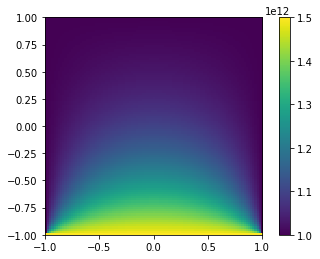

In [5]:
n = 101
m = 20000                                   

# Create input u and set the boundary condition.
u = np.full((n, n), 1_000_000_000_000, dtype=np.int64)   
u[0, :] = 1_500_000_000_000                               

i = 0

with Timer() as t:    
    while u[(n - 1) // 2, (n - 1) // 2] < 1_100_000_000_000:
        u[1: n - 1, 1: n - 1] = u[1: n - 1, 1: n - 1] - (4 * u[1: n - 1, 1: n - 1] -
                                                          u[0: n - 2, 1: n - 1] -
                                                          u[2: n, 1: n - 1] -
                                                          u[1: n - 1, 2: n] -
                                                          u[1: n - 1, 0: n - 2]) * (n - 1) * (n - 1) / (4 * m)
        i = i + 1
    
print("t* =", i / m)
print("Total time: {0}".format(t.interval))

plt.figure()
plt.imshow(u, origin='lower', extent=(-1, 1, -1, 1))
plt.colorbar()
plt.show()

## Array
### float 64

t* = 0.424
Total time: 0.9135565757751465


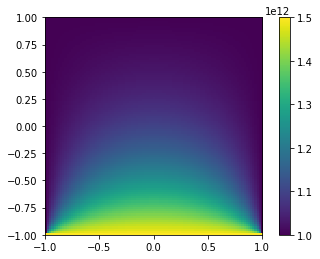

In [6]:
n = 101
m = 20000                                   

# Create input u and set the boundary condition.
u = np.full((n, n), 1_000_000_000_000, dtype=np.float64)   
u[0, :] = 1_500_000_000_000                               

i = 0

with Timer() as t:    
    while u[(n - 1) // 2, (n - 1) // 2] < 1_100_000_000_000:
        u[1: n - 1, 1: n - 1] = u[1: n - 1, 1: n - 1] - (4 * u[1: n - 1, 1: n - 1] -
                                                          u[0: n - 2, 1: n - 1] -
                                                          u[2: n, 1: n - 1] -
                                                          u[1: n - 1, 2: n] -
                                                          u[1: n - 1, 0: n - 2]) * (n - 1) * (n - 1) / (4 * m)
        i = i + 1
          
print("t* =", i / m)
print("Total time: {0}".format(t.interval))

plt.figure()
plt.imshow(u, origin='lower', extent=(-1, 1, -1, 1))
plt.colorbar()
plt.show()

## Array Numexpr
### float 64

t* = 0.424
Total time: 1.5777814388275146


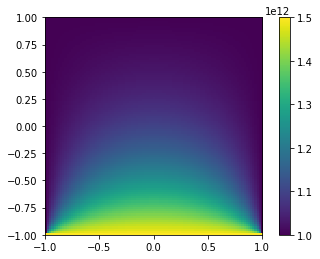

In [7]:
n = 101
m = 20000                                   

# Create input u and set the boundary condition.
u = np.full((n, n), 1_000_000_000_000, dtype=np.float64)   
u[0, :] = 1_500_000_000_000                               

i = 0

with Timer() as t:    
    while u[(n - 1) // 2, (n - 1) // 2] < 1_100_000_000_000:
        a = u[1: n - 1, 1: n - 1]
        b = u[0: n - 2, 1: n - 1]
        c = u[2: n, 1: n - 1]
        d = u[1: n - 1, 2: n]
        e = u[1: n - 1, 0: n - 2]
        u[1: n - 1, 1: n - 1] = ne.evaluate("a - (4 * a - b - c - d - e ) * (n - 1) * (n - 1) / (4 * m)")
        i = i + 1
 
print("t* =", i / m)
print("Total time: {0}".format(t.interval))

plt.figure()
plt.imshow(u, origin='lower', extent=(-1, 1, -1, 1))
plt.colorbar()
plt.show()

## Array RK4
### float 64

t* = 0.42405
Total time: 4.606718063354492


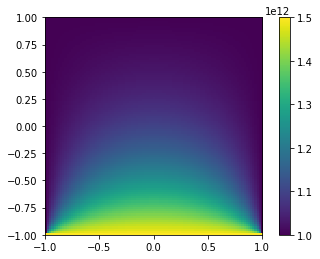

In [8]:
@njit
def f_a_fl(n, m, u, v):
    a = u[1: n - 1, 1: n - 1]
    b = u[0: n - 2, 1: n - 1]
    c = u[2: n, 1: n - 1]
    d = u[1: n - 1, 2: n]
    e = u[1: n - 1, 0: n - 2]
    v[1: n - 1, 1: n - 1] = (b + c + d + e - 4 * a) * (n - 1) * (n - 1) / (4 * m)

@njit
def f_a_rk4_fl(n, m, u):
    k1 = np.full((n, n), 0.0, dtype=np.float64)
    k2 = np.full((n, n), 0.0, dtype=np.float64)
    k3 = np.full((n, n), 0.0, dtype=np.float64)
    k4 = np.full((n, n), 0.0, dtype=np.float64)
    
    f_a_fl(n, m, u, k1)
    f_a_fl(n, m, u + k1 / 2, k2)
    f_a_fl(n, m, u + k2 / 2, k3)
    f_a_fl(n, m, u + k3, k4)

    return u + (k1 + k2 * 2 + k3 * 2 + k4) / 6


n = 101
m = 20000                                   

# Create input u and set the boundary condition.
u = np.full((n, n), 1_000_000_000_000, dtype=np.float64)   
u[0, :] = 1_500_000_000_000                               

i = 0

with Timer() as t:    
    while u[(n - 1) // 2, (n - 1) // 2] < 1_100_000_000_000:
        u = f_a_rk4_fl(n, m, u)
        i = i + 1
            
print("t* =", i / m)
print("Total time: {0}".format(t.interval))

plt.figure()
plt.imshow(u, origin='lower', extent=(-1, 1, -1, 1))
plt.colorbar()
plt.show()

## OpenCL
### float 32

In [9]:
kernel_string = """

__kernel void opencl_float(const int n, const int m, 
                           __global float *u, __global float *v, 
                           __global float *tp)
{   
    int r = get_global_id(0);
    int c = get_global_id(1);
    
    // Finite differences for the points inside the space.
    
    if (r > 0 && r < n - 1 && c > 0 && c < n - 1){
        v[n * r + c] = u[n * r + c] - \
            (4 * u[n * r + c] - u[n * (r - 1) + c] - u[n * (r + 1) + c] - u[n * r + (c - 1)] - u[n * r + (c + 1)])
             * (n - 1) * (n - 1) / (4 * m);
    }
    else{
        v[n * r + c] = u[n * r + c];
        return;
    }

    if (r == (n - 1) / 2 && c == (n - 1) / 2){
        tp[0] = u[n * r + c];
    }
        
    // For iteration.   
    u[n * r + c] = v[n * r + c];  
}

"""


In [10]:
# Define the class.
class OpenCLfloat:

    
    def __init__(self, n, m):
        """Initialse this function."""
        self._n = n
        self._m = m
        
        # Create context.
        self._ctx = cl.create_some_context()        
        self._queue = cl.CommandQueue(self._ctx, properties = cl.command_queue_properties.PROFILING_ENABLE)       
        mf = cl.mem_flags  
        
        # Create input and output buffers, u and v. 
        self._u = cl.Buffer(self._ctx, mf.READ_WRITE, size=np.dtype(np.float32).itemsize * n * n)
        self._v = cl.Buffer(self._ctx, mf.READ_WRITE, size=np.dtype(np.float32).itemsize * n * n)
                
        # Create a buffer to hold the current temperature of the centre of the plate.        
        self._tp = cl.Buffer(self._ctx, mf.READ_WRITE, size=np.dtype(np.float32).itemsize)

        # Build the kernel.       
        self._kernel = cl.Program(self._ctx, kernel_string).build().opencl_float


    def input_u(self, u):
        cl.enqueue_copy(self._queue, self._u, u)


    def input_v(self, v):
        cl.enqueue_copy(self._queue, self._v, v)

        
    def output_u(self):
        v = np.zeros((self._n, self._n), dtype=np.float32)
        cl.enqueue_copy(self._queue, u, self._u)            
        return v


    def output_v(self):
        v = np.zeros((self._n, self._n), dtype=np.float32)
        cl.enqueue_copy(self._queue, v, self._v)            
        return v


    def output_tp(self):
        tp = np.zeros((1), dtype=np.float32)
        cl.enqueue_copy(self._queue, tp, self._tp)            
        return tp[0]

           
    def run(self):
        self._kernel(self._queue, (self._n, self._n), None,
                     np.int32(self._n), np.int32(self._m),
                     self._u, self._v, self._tp)

t*= 0.4183
Total time: 0.8157880306243896


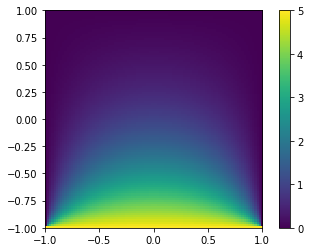

In [11]:
n = 101
m = 10000

u = np.zeros((n, n), dtype=np.float32)
v = np.zeros((n, n), dtype=np.float32)

u[0, :] = 5.0

of = OpenCLfloat(n, m)

of.input_u(u)
of.input_v(u)

i = 0

with Timer() as t:
    
    while True:
        of.run()
        i = i + 1
        tp = of.output_tp()
        if tp >= 1.0:
            u = of.output_v()            
            break

print("t*=", i / m)
print("Total time: {0}".format(t.interval))

plt.figure()
plt.imshow(u, origin='lower', extent=(-1, 1, -1, 1))
plt.colorbar()
plt.show()

I try different courant number:

We set:

### Test 1

<font color="green">$n = 201$

$m = 40000$

$c = \frac {(n - 1) (n-1) } {4m} = 0.25$  (Courant Nmber)</font>

Numba int 64:  

t* = 0.424    

Total time: 3.2971837520599365

Numba float 64:

t* = 0.424

Total time: 1.4691026210784912

Array int 64:

t* = 0.424

Total time: 8.34070348739624

Array float 64:

t* = 0.424

Total time: 5.907242774963379

Array Numexpr float 64:

t* = 0.424

Total time: 6.124628782272339

Array RK4 float 64:

t* = 0.424025

Total time: 26.1611008644104

OpenCL float 32:

t*= 0.420375

Total time: 5.045481443405151

### Test 2

<font color="green">$n = 101$

$m = 10000$

$c = \frac {(n - 1) (n-1) } {4m} = 0.25$  (Courant Nmber)</font>

Numba int 64:

t* = 0.424

Total time: 0.5644629001617432

Numba float 64:

t* = 0.424

Total time: 0.3341333866119385

Array int 64:

t* = 0.424

Total time: 0.685136079788208

Array float 64:

t* = 0.424

Total time: 0.45677924156188965

Array Numexpr float 64:

t* = 0.424

Total time: 0.8208050727844238

Array RK4 float 64:

t* = 0.4241

Total time: 3.3450891971588135

OpenCL float 32:

t*= 0.4184

Total time: 0.8736639022827148

# Conclusion


When using float 32, the program run faster than using int 64 and float 64.

Apply <font color="green">@njit Numexpr RK4 Numba OpenCL Array</font> inside this coursework. <font color="green">RK4 can make the program more accurate. @njit and Numexpr can improve the program efficient.</font> 

The speed of running program: <font color="green">Numba $>$ Array $>$ OpenCL</font>.

To sum up, courant number is a factor of raising accuracy which working with $n$, $m$. To improve accuracy, need to increase the values of n and m. Courant number can make the program stable to run when its value is less than 0.25.   

# Additional Test 

### <font color="green">Please do not add in testing time, since it runs too slow.</font>


To get more significant digits, I use Array Numexpr float 64 scheme with larger n and m, and the number of siginificant digits achieve to 12.

t* = 0.424011328125
Total time: 478.7468636035919


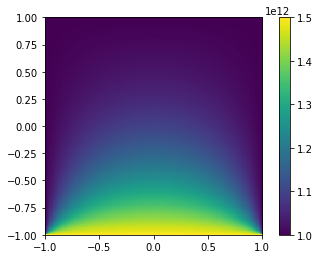

In [12]:
n = 201
m = 2560000                                   

# Create input u and set the boundary condition.
u = np.full((n, n), 1_000_000_000_000, dtype=np.float64)   
u[0, :] = 1_500_000_000_000                               

i = 0

with Timer() as t:    
    while u[(n - 1) // 2, (n - 1) // 2] < 1_100_000_000_000:
        a = u[1: n - 1, 1: n - 1]
        b = u[0: n - 2, 1: n - 1]
        c = u[2: n, 1: n - 1]
        d = u[1: n - 1, 2: n]
        e = u[1: n - 1, 0: n - 2]
        u[1: n - 1, 1: n - 1] = ne.evaluate("a - (4 * a - b - c - d - e ) * (n - 1) * (n - 1) / (4 * m)")
        i = i + 1
 
print("t* =", i / m)
print("Total time: {0}".format(t.interval))

plt.figure()
plt.imshow(u, origin='lower', extent=(-1, 1, -1, 1))
plt.colorbar()
plt.show()